# FINAL REPORT

Course: Applied Parallel Programming

18127039 -  Lâm Ngọc Phương Anh

18127046 - Lư Ngọc Liên 

1653098 - Võ Minh Tú


# Enhancing Document Image


## Problem Statement

### Overview
Enhancing document image is a fundamental stage in image processing which support scan images, convert images to text, and re-align shooting angles,...

Common applications where this problem applies are:
- Scanning function of iPhone Notes 
- CamScanner app


 
### Input and Output Data description
* Input: a document image is not facing toward the screen.
* Output: the document image (cut the background) faces toward the screen.
* Example of input and output:

![](https://i.imgur.com/8cfHARR.png)

*cre*: [dropbox.Tech, Jongmin Baek, Aug 16, 2016, Fast document rectification and enhancement](https://dropbox.tech/machine-learning/fast-document-rectification-and-enhancement)

* **Steps of processing the image from Input to Output**
    * Detect edges
    * Get the document's contour based on the detected edges above.
    * Apply transform to get the top-down view of the image.
    * Adjust the contrast and light to make the document easier to read.

### Should we need to apply parallel to speed up the running time of this problem? Is it available to be paralleled?


First of all, we discuss the benefit of parallel can help: 
* Parallel computing saves time, allowing the execution of applications in a shorter wall-clock time.
* Solve Larger Problems in a short point of time.
* Compared to serial computing, parallel computing is much better suited for modeling, simulating and understanding complex, real-world phenomena.
* Throwing more resources at a task will shorten its time to completion, with potential cost savings. Parallel computers can be built from cheap, commodity components.
* Many problems are so large and/or complex that it is impractical or impossible to solve them on a single computer, especially given limited computer memory.
* You can do many things simultaneously by using multiple computing resources.
* Can using computer resources on the Wide Area Network(WAN) or even on the internet.
* It can help keep you organized. If you have Internet, then communication and social networking can be made easier.
* It has massive data storage and quick data computations.


Secondly, we discuss why Enhance Document Image need parallel programming to speed up and applications of its and it is available to be paralleled.
* As we declare above, we have 4 steps to do so as to enhance and scanner a image into a online doc from a picture. And in every steps, we have so many tasks to do complicated. This leads to takes us quite big amount of time to do this serially. => Time
* The second benefit when using parallel that we can do many things simultaneously by using multiple computing resources. Example: In real world, we not only do a function for an object at the particular. Imagine that we have 4 pictures or even more to scan at the same time, we cannot wasting time by letting system assign this for single core while we can do this for all gpu and cpu cores that we have. So that’s why we can use multiple computing resources effectively and efficiently.

### Weekly plan

<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-rk9a">Main task</th>
    <th class="tg-rk9a">Sub-task</th>
    <th class="tg-rk9a">Assignee</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-9hil" rowspan="5">W05</td>
    <td class="tg-9wq8" rowspan="3">Write report about problem statement</td>
    <td class="tg-0pky">Describe problem</td>
    <td class="tg-kgv7"><span style="color:#000">Lư Ngọc Liên</span></td>
  </tr>
  <tr>
    <td class="tg-0pky">Describe data</td>
    <td class="tg-kgv7"><span style="color:#000">Lâm Ngọc Phương Anh</span></td>
  </tr>
  <tr>
    <td class="tg-0pky">The need of parallel</td>
    <td class="tg-kgv7"><span style="color:#000">Võ Minh Tú</span></td>
  </tr>
  <tr>
    <td class="tg-9wq8" rowspan="2">Refer the process of different solutions</td>
    <td class="tg-0pky">Read idea</td>
    <td class="tg-0pky">All Team</td>
  </tr>
  <tr>
    <td class="tg-0pky">Note the strong point of each idea</td>
    <td class="tg-0pky">All Team</td>
  </tr>
</tbody>
</table>


In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
from numpy import asarray
import numpy as np
from numba import jit
import time
from google.colab.patches import cv2_imshow
import cv2
import imutils
from skimage.filters import threshold_local

In [ ]:
img = asarray(Image.open('img.png'))

### Làm xám ảnh

#### Cách 1: Dùng openCV

Processing time: 0.0005068778991699219 s


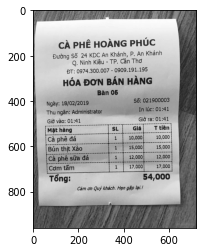

In [ ]:
start = time.time()
gray_cv = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
end = time.time()

print(f'Processing time: {end - start} s')
plt.imshow(gray_cv, cmap ='gray');

In [ ]:
gray_cv

array([[120, 112, 109, ...,  59,  65,  76],
       [114, 111, 113, ...,  60,  71,  86],
       [110, 110, 111, ...,  69,  84,  99],
       ...,
       [ 75,  84,  89, ...,  80,  81,  83],
       [ 73,  83,  88, ...,  81,  82,  83],
       [ 72,  82,  85, ...,  84,  84,  86]], dtype=uint8)

#### Cách 2: Dùng numpy

Processing time: 0.007577657699584961 s


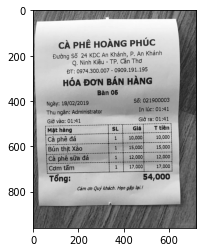

In [ ]:
start = time.time()
B, G, R = img[:,:,0], img[:,:,1], img[:,:,2]
gray_np = 0.299 * R + 0.587 * G + 0.114 * B
end = time.time()

print(f'Processing time: {end - start} s')

plt.imshow(gray_np, cmap='gray');

In [ ]:
type(gray_np)

numpy.ndarray

In [ ]:
np.mean(abs(gray_cv - gray_np))

0.2724917635995377

#### Cách 3: Dùng @jit

Processing time: 0.0528867244720459 s


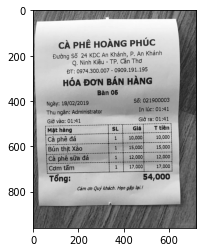

In [ ]:
@jit(cache=True)
def convert_gray(in_img, out_img, width, height):
  for i in range(height):
    for j in range(width):
      out_img[i,j] = 0.299 * in_img[i,j][2] + 0.587 * in_img[i,j][1]  + 0.114 * in_img[i,j][0]

height, width, _ = img.shape

start = time.time()
gray_jit = np.empty((height, width))
convert_gray(img, gray_jit, width, height)
end = time.time()
print(f'Processing time: {end - start} s')

plt.imshow(gray_jit, cmap='gray');

In [ ]:
gray_jit

array([[120.355, 112.355, 109.355, ...,  59.095,  65.095,  76.095],
       [114.355, 111.355, 113.355, ...,  60.095,  71.095,  86.095],
       [110.355, 110.355, 111.355, ...,  69.095,  84.095,  99.095],
       ...,
       [ 75.355,  84.355,  89.355, ...,  79.796,  80.796,  82.796],
       [ 73.355,  83.355,  88.355, ...,  80.796,  81.796,  83.437],
       [ 72.355,  82.355,  85.355, ...,  83.796,  84.437,  86.437]])

In [ ]:
np.mean(abs(gray_cv - gray_jit))

0.2724917635995377

### Detect cạnh

Phát hiện biên cạnh là bước tìm ra các biên thuộc các đối tượng trong ảnh, nhầm phân tách và biết được hình dạng (shape) các đối tượng đó.

Có 2 thuật toán nổi tiếng cho bài toán này là Sobel edge detector và Canny edge detector

Trong bài toán này nhóm xin chọn sử dụng thuật toán Canny edge detector. Thuật toán gồm 4 bước
- Giảm nhiễu: tiến hành làm mờ và giảm nhiễu cho bức ảnh bằng Gaussian ([Công thức của Gaussian Filter](https://docs.opencv.org/2.4/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter))
- Tình Gradient và hướng gradient: Sử dụng bộ lọc Sobel X và Sobel Y để lấy ra được đạo hàm theo chiều ngang (Gx) và dọc của bức ảnh (Gy). Từ đó ta sẽ tính được  gradient (độ lớn của sự biến đổi mức sáng ở vị trí pixel tương ứng với ảnh gốc) và hướng của từng pixel trong ảnh theo công thức sau. Trong đó hướng của cạnh được chia thành 4 hướng đại diện: ngang (0 độ), chéo bên phải (45 độ), dọc (90 độ), chéo bên trái (135 độ). 

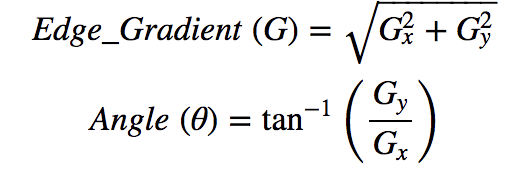
- Tính non-max suppression: Mục đích lọc bỏ các pixel không phải là cực đại cục bộ. Ta sử dụng 1 filter 3x3 chạy lần lượt qua các pixel của ảnh sau khi đã gradient. Trong các lần chạy, ta xét độ lớn của pixel hiện tại có phải là cực đại so với 2 hàng xóm (dựa trên hướng gradient)  hay không. Nếu là cực đại thì ghi nhận lại pixel đó, ngược lại set độ lớn của pixel đó bằng 0.
- Lọc ngưỡng: ở đây ta có 2 giá trị được gọi là maxVal và minVal. Nếu pixel hiện tại có giá trị lớn hơn maxVal thì pixel đó là cạnh, nhỏ hơn minVal thì bị loại bỏ. Còn các pixel nằm giữa maxVal và minVal, ta sẽ xét nó nằm gần với bên nào để quyết định có giữ lại nó hay không. 



#### Dùng @jit

In [ ]:
def scale_to_0_255(img):
    min_val = np.min(img)
    max_val = np.max(img)
    new_img = (img - min_val) / (max_val - min_val) # 0-1
    new_img *= 255
    return new_img

In [ ]:
#https://minhng.info/tutorials/xu-ly-anh-opencv-hien-thuc-canny-edge.html
@jit
def my_canny(min_val, max_val, Gx, Gy, smooth_img, is_L2_gradient=False):
    """
    Try to implement Canny algorithm in OpenCV tutorial @ https://docs.opencv.org/master/da/d22/tutorial_py_canny.html
    """
    if is_L2_gradient:
        edge_gradient = np.sqrt(Gx*Gx + Gy*Gy)
    else:
        edge_gradient = np.abs(Gx) + np.abs(Gy)
    
    angle = np.arctan2(Gy, Gx) * 180 / np.pi
    
    # round angle to 4 directions
    angle = np.abs(angle)
    angle[angle <= 22.5] = 0
    angle[angle >= 157.5] = 0
    angle[(angle > 22.5) * (angle < 67.5)] = 45
    angle[(angle >= 67.5) * (angle <= 112.5)] = 90
    angle[(angle > 112.5) * (angle <= 157.5)] = 135
    
    #4. Non-maximum Suppression
    keep_mask = np.zeros(smooth_img.shape, np.uint8)
    for y in range(1, edge_gradient.shape[0]-1):
        for x in range(1, edge_gradient.shape[1]-1):
            area_grad_intensity = edge_gradient[y-1:y+2, x-1:x+2] # 3x3 area
            area_angle = angle[y-1:y+2, x-1:x+2] # 3x3 area
            current_angle = area_angle[1,1]
            current_grad_intensity = area_grad_intensity[1,1]
            
            if current_angle == 0:
                if current_grad_intensity > max(area_grad_intensity[1,0], area_grad_intensity[1,2]):
                    keep_mask[y,x] = 255
                else:
                    edge_gradient[y,x] = 0
            elif current_angle == 45:
                if current_grad_intensity > max(area_grad_intensity[2,0], area_grad_intensity[0,2]):
                    keep_mask[y,x] = 255
                else:
                    edge_gradient[y,x] = 0
            elif current_angle == 90:
                if current_grad_intensity > max(area_grad_intensity[0,1], area_grad_intensity[2,1]):
                    keep_mask[y,x] = 255
                else:
                    edge_gradient[y,x] = 0
            elif current_angle == 135:
                if current_grad_intensity > max(area_grad_intensity[0,0], area_grad_intensity[2,2]):
                    keep_mask[y,x] = 255
                else:
                    edge_gradient[y,x] = 0
    
    #5. Hysteresis Thresholding    
    canny_mask = np.zeros(smooth_img.shape, np.uint8)
    canny_mask[(keep_mask>0) * (edge_gradient>min_val)] = 255
    
    return canny_mask


In [ ]:
smooth_img = cv2.GaussianBlur(gray_cv, ksize=(5, 5), sigmaX=1, sigmaY=1) #remove noise
#3. Finding Intensity Gradient of the Image
Gx = cv2.Sobel(smooth_img, cv2.CV_64F, 1, 0, ksize=3)
Gy = cv2.Sobel(smooth_img, cv2.CV_64F, 0, 1, ksize=3)

<ipython-input-12-15d3fd70d375>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "my_canny" failed type inference due to: No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 2d, C), array(bool, 2d, C), Literal[int](0))
 
There are 16 candidate implementations:
      - Of which 14 did not match due to:
      Overload of function 'setitem': File: <numerous>: Line N/A.
        With argument(s): '(array(float64, 2d, C), array(bool, 2d, C), int64)':
       No match.
      - Of which 2 did not match due to:
      Overload in function 'SetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 171.
        With argument(s): '(array(float64, 2d, C), array(bool, 2d, C), int64)':
       Rejected as the implementation raised a specific error:
         TypeError: unsupported array index type array(bool, 2d, C) in [array(bool, 2d, C)]
  raised from /usr/local/lib/python3.

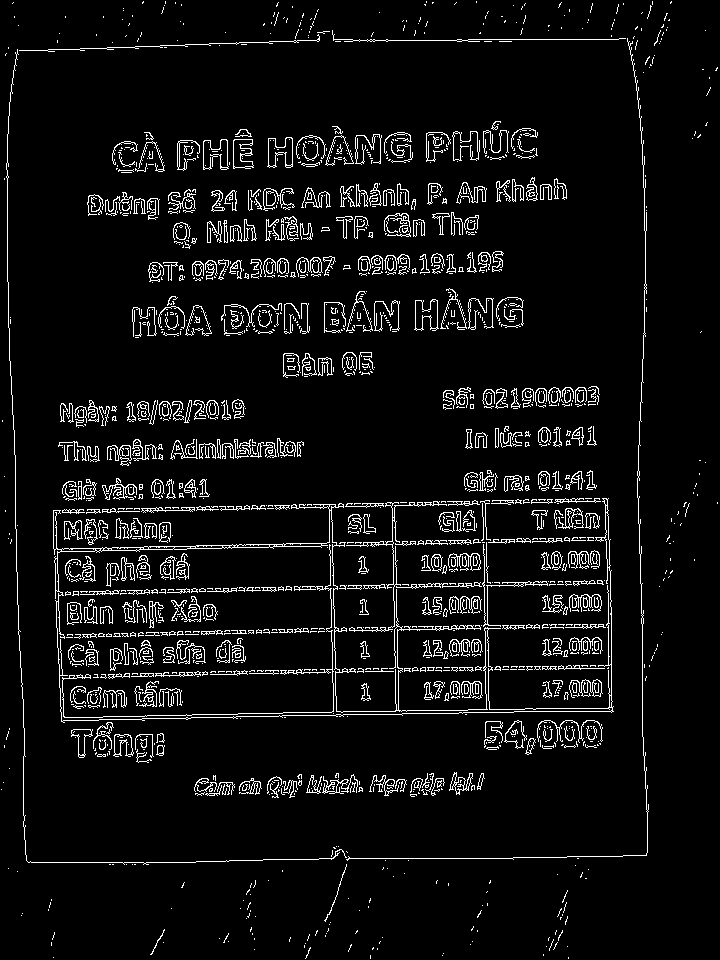

In [ ]:
canny_jit = my_canny(min_val=150, max_val=200, Gx = Gx, Gy = Gy, smooth_img= smooth_img);
cv2_imshow(canny_jit)

#### Dùng Opencv

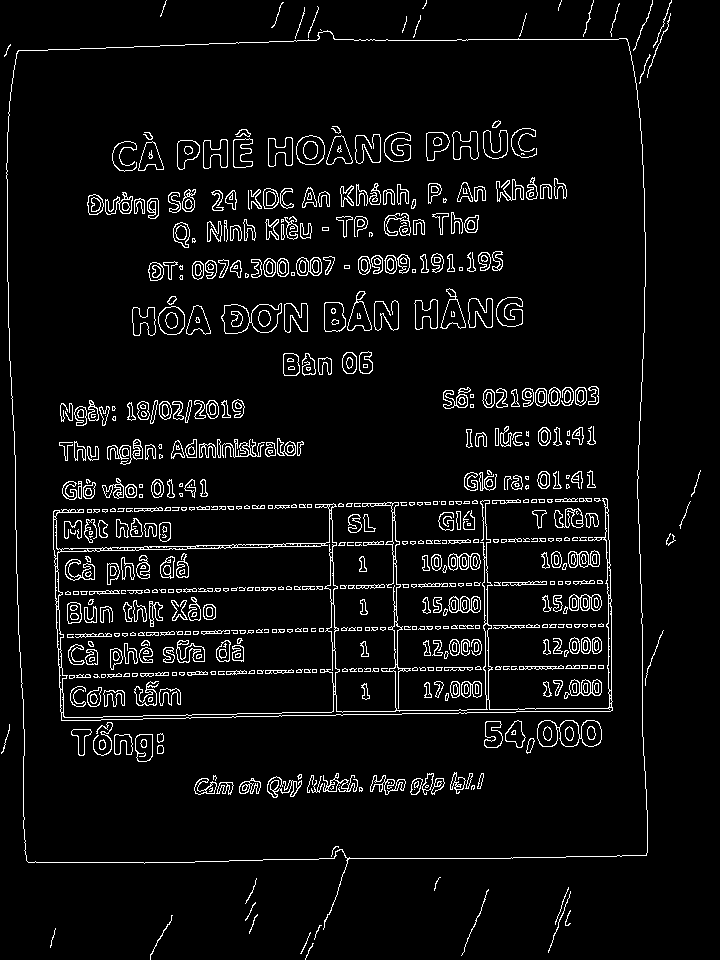

In [ ]:
gaussian = cv2.GaussianBlur(gray_cv,(3,3),cv2.BORDER_DEFAULT)
canny_cv = cv2.Canny(gaussian, 100, 200)
cv2_imshow(canny_cv)

In [ ]:
np.mean(abs(canny_cv - canny_jit))

1.8062268518518518

In [ ]:
# ret, thresh = cv2.threshold(canny_cv, 150, 255, cv2.THRESH_BINARY)
# contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# contour = max(contours, key = cv2.contourArea)
# temp = img.copy()
# contourImg = cv2.drawContours(temp, contour, -1, (0,255,0), 2)
# cv2_imshow(contourImg)

In [ ]:
#https://stackoverflow.com/questions/62039403/python-opencv-finding-the-biggest-contour
#https://docs.opencv.org/3.1.0/d4/d73/tutorial_py_contours_begin.html
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
# https://seal.deha.vn/gioi-thieu-ve-homography-trong-opencv/

In [ ]:
# https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
# https://pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

### Find contours

STEP 2: Find contours of paper


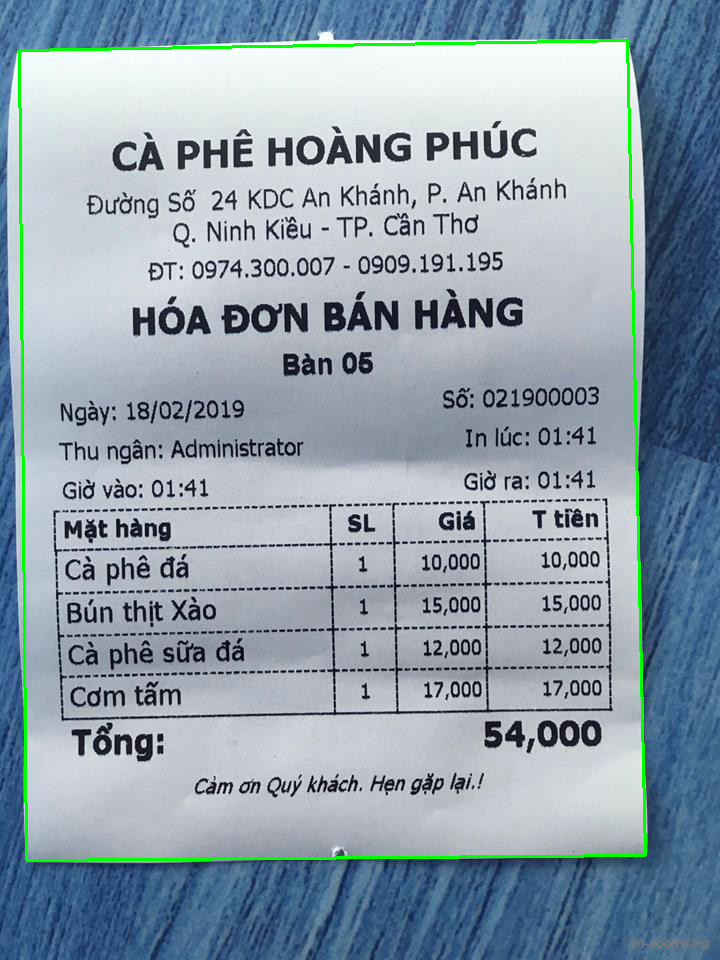

In [ ]:
cnts = cv2.findContours(canny_cv.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 2)
cv2_imshow(img)

### Re-align image

In [ ]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

In [ ]:

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

STEP 3: Apply perspective transform
Origin image


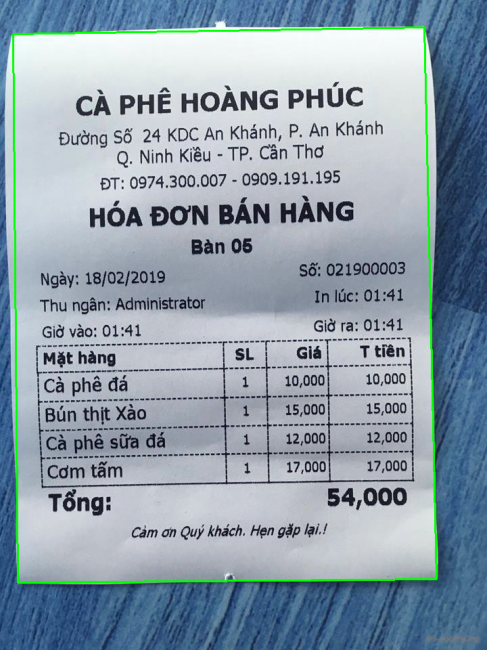

Scanned image


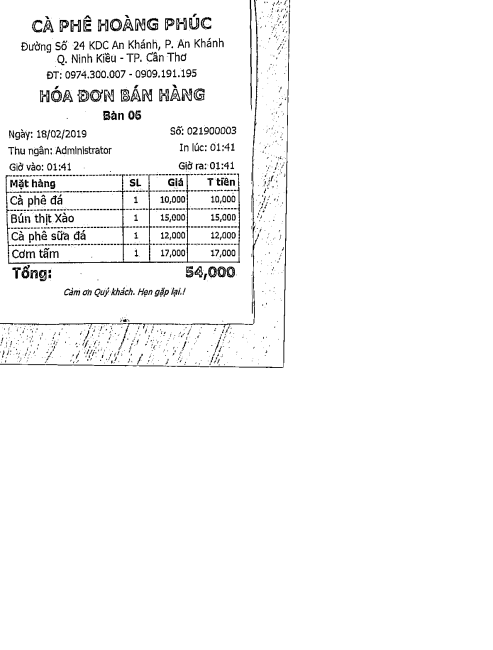

In [ ]:
ratio = img.shape[0] / 500.0
warped = four_point_transform(img, screenCnt.reshape(4, 2) * ratio)
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
# show the original and scanned images
print("STEP 3: Apply perspective transform")
print("Origin image")
cv2_imshow(imutils.resize(img, height = 650))
print("Scanned image")
cv2_imshow(imutils.resize(warped, height = 650))

### Change brightness

In [ ]:
img = cv2.cvtColor(warped, cv2.COLOR_GRAY2BGR)

In [ ]:
# https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

In [ ]:
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)  
    return img

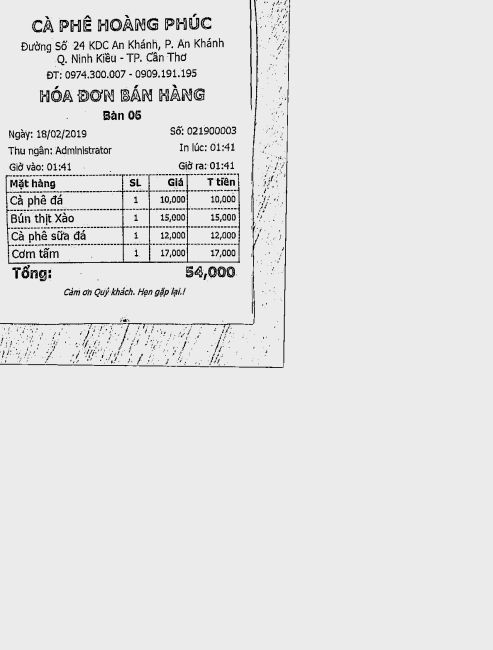

In [ ]:
cv2_imshow(imutils.resize(change_brightness(img.copy(), value=-20), height = 650))

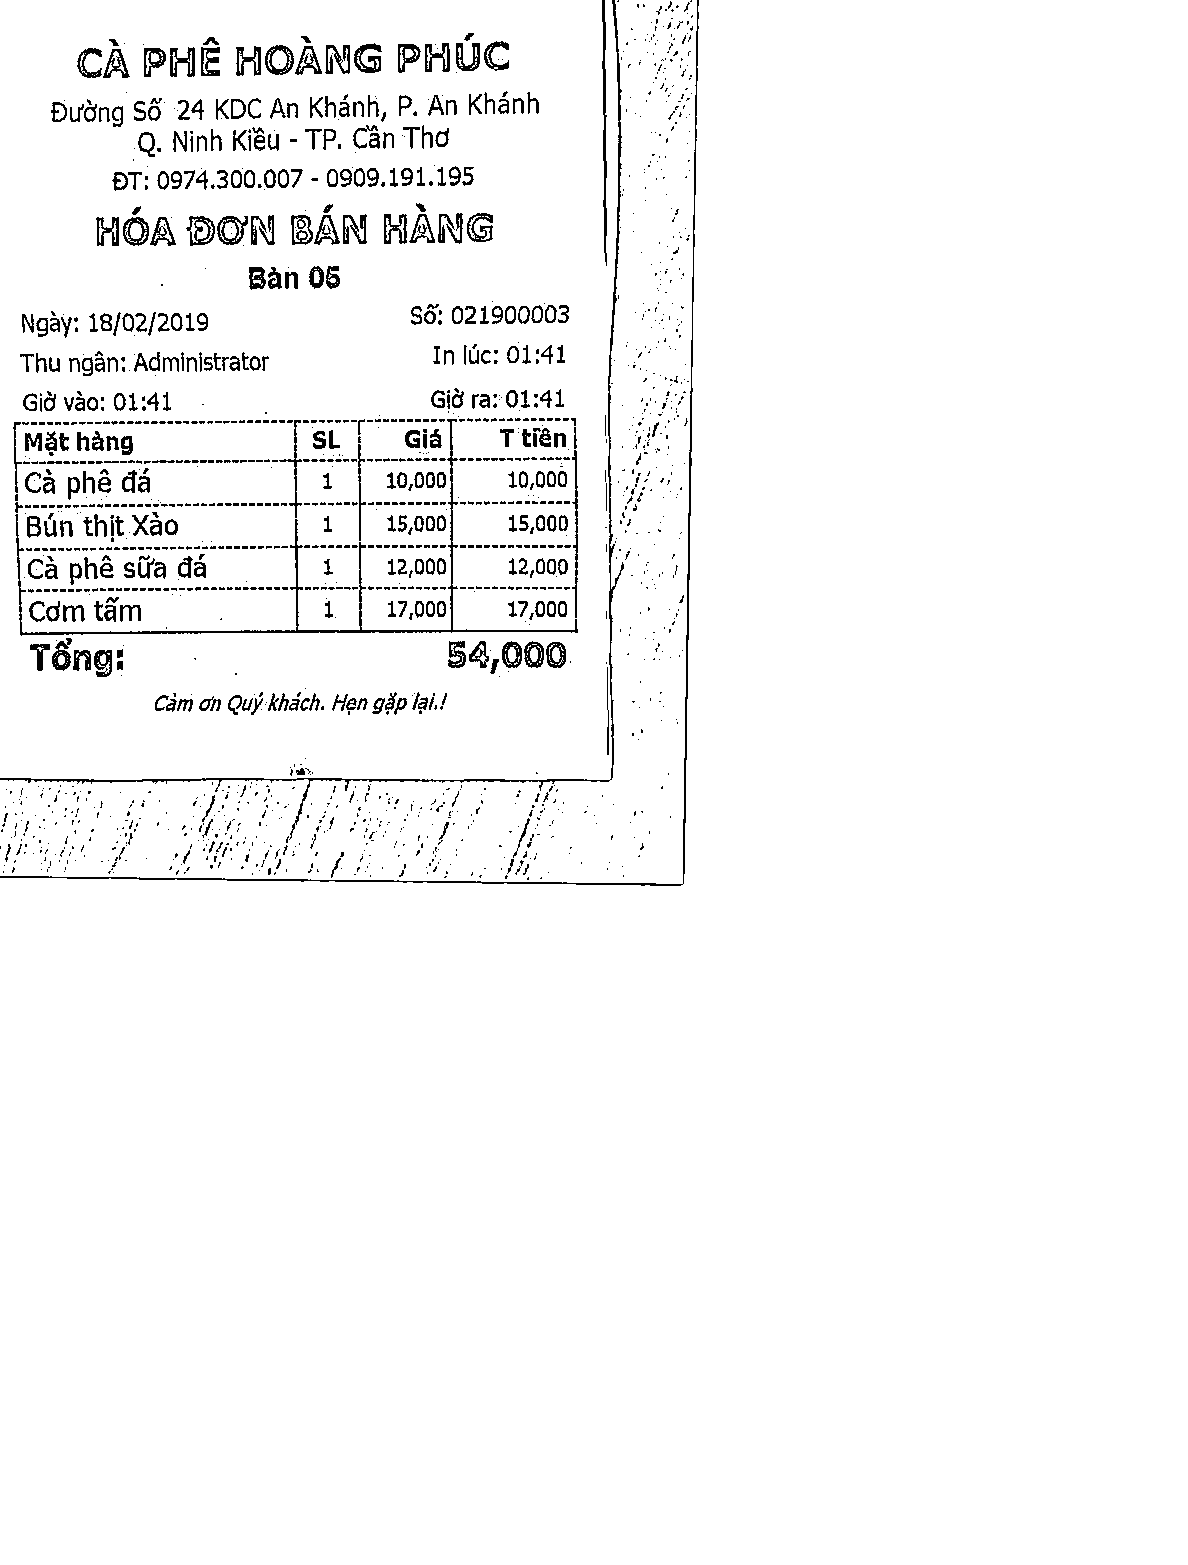

In [ ]:
new_image = np.zeros(img.shape, img.dtype)
alpha, beta = 1.5, 2
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        for c in range(img.shape[2]):
            new_image[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
cv2_imshow(new_image)